In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

data_NSE = pd.read_csv("NIFTY_50_His_Data_Reversed.csv")
data_NYSE = pd.read_csv("NYSE_His_Data.csv")

data_NSE["Date"] = pd.to_datetime(data_NSE["Date"], dayfirst=True)
data_NYSE['Date'] = pd.to_datetime(data_NYSE['Date'])

data_nse = data_NSE.sort_values('Date').reset_index(drop=True)
data_nyse = data_NYSE.sort_values('Date').reset_index(drop=True)

data_nse['Close'] = data_nse['Close'].astype(float)
data_nyse['Close'] = data_nyse['Close'].astype(float)

nse_returns = np.log(data_nse['Close']).diff().dropna().to_numpy()
nyse_returns = np.log(data_nyse['Close']).diff().dropna().to_numpy()


min_len = min(len(nse_returns),len(nyse_returns))
nse_returns = nse_returns[-min_len:]
nyse_returns = nyse_returns[-min_len:]

window_size = 5
X_cond,Y_target = [],[]

for i in range(window_size,len(nyse_returns)-1):
    X_cond.append(nyse_returns[i-window_size:i])
    Y_target.append(nse_returns[i+1])

X_cond = np.array(X_cond)
Y_target = np.array(Y_target)

scaler_x,scaler_y=StandardScaler(),StandardScaler()

X_cond_scaled = scaler_x.fit_transform(X_cond)
Y_target_scaled = scaler_y.fit_transform(Y_target.reshape(-1,1)).flatten()

# print(X_cond_scaled.shape,Y_target_scaled.shape)


(240, 5) (240,)


C:\Users\kumar\AppData\Local\Temp\ipykernel_23352\1448798847.py:8: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data_NSE["Date"] = pd.to_datetime(data_NSE["Date"], dayfirst=True)


# Model

In [97]:
from tensorflow.keras.layers import Input,Dense,Concatenate
from tensorflow.keras import Model

# DDPM-style denoiser with MLP layers:
def get_denoising_model(cond_dim,noise_dim=1,hidden_dim=64):
    noisy_input = Input(shape=(noise_dim,))
    cond_input = Input(shape=(cond_dim,))

    x = Concatenate()([noisy_input,cond_input])
    x = Dense(hidden_dim,activation="relu")(x)
    x = Dense(hidden_dim,activation="relu")(x)
    out = Dense(noise_dim)(x)

    return Model(inputs=[noisy_input,cond_input],outputs=out)

In [98]:
# Training for Conditional Denoising
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError

model = get_denoising_model(cond_dim=5)

model.compile(
    optimizer=Adam(0.001),
    loss=MeanSquaredError()
)

X_tensor = tf.convert_to_tensor(X_cond_scaled,dtype=tf.float32)
Y_tensor = tf.convert_to_tensor(Y_target_scaled.reshape(-1,1),dtype=tf.float32)

dataset = tf.data.Dataset.from_tensor_slices((X_tensor, Y_tensor))
dataset = dataset.shuffle(buffer_size=512).batch(32) 

def map_to_conditional_inputs(condition, target):
    noise = tf.random.normal(shape=tf.shape(target))
    noisy_target = target+noise
    return (noisy_target, condition), noise

conditional_dataset = dataset.map(map_to_conditional_inputs)
conditional_dataset = conditional_dataset.prefetch(tf.data.AUTOTUNE)

model.compile(
    optimizer=Adam(0.001),
    loss=MeanSquaredError()
)

model.fit(conditional_dataset, epochs=300)

Epoch 1/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7486  
Epoch 2/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6976 
Epoch 3/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5876 
Epoch 4/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5894 
Epoch 5/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4533 
Epoch 6/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5334 
Epoch 7/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4002 
Epoch 8/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5415 
Epoch 9/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4701 
Epoch 10/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4187 
Epoch 11/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5045 
Epoch 12/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3950 
Epoch 13/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5082 
Epoch 14/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4076 
Epoch 15/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4463 
Epoch 16/300
8/8 ━

### NSE Return

In [100]:
def sample_nse_return(x_cond_np, model):
    x_cond = tf.convert_to_tensor(x_cond_np, dtype=tf.float32)  # shape (1, 5)
    y_noisy = tf.random.normal(shape=(1, 1))
    epsilon_pred = model.predict([y_noisy, x_cond], verbose=0)
    y_denoised = y_noisy - epsilon_pred
    return y_denoised.numpy().flatten()


last_6_prices = data_nyse['Close'].to_numpy()[-6:]
last_5_returns = np.log(last_6_prices[1:] / last_6_prices[:-1]) 
x_cond_input_scaled = scaler_x.transform(last_5_returns.reshape(1, -1))  # shape: (1, 5)


n_samples = 1000
samples_scaled = np.array([sample_nse_return(x_cond_input_scaled, model) for _ in range(n_samples)])

# Inverse transform to get actual log returns
samples_real = scaler_y.inverse_transform(samples_scaled.reshape(-1, 1)).flatten()

# Get expected return and standard deviation
expected_return = np.mean(samples_real)
std_dev = np.std(samples_real)

# Convert to % price change
percent_change = (np.exp(expected_return) - 1) * 100

print("Predicted NSE log-return for 1 June 2025:", expected_return)
print("Standard deviation:", std_dev)
print("Expected % change in NSE on 1 June 2025:", percent_change, "%")



Predicted NSE log-return for 1 June 2025: 0.0027295204
Standard deviation: 0.001286808
Expected % change in NSE on 1 June 2025: 0.27332306 %


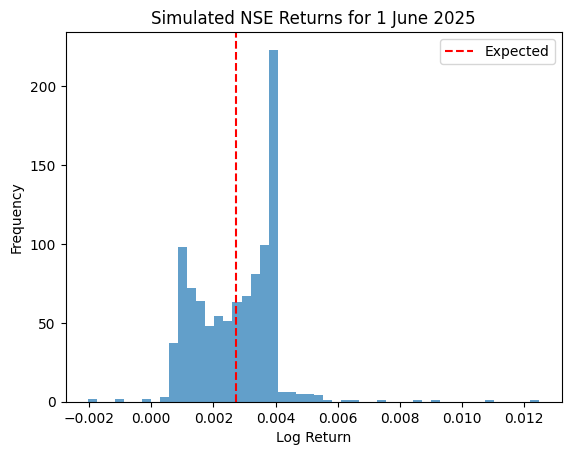

In [101]:
import matplotlib.pyplot as plt
plt.hist(samples_real, bins=50, alpha=0.7)
plt.title("Simulated NSE Returns for 1 June 2025")
plt.xlabel("Log Return")
plt.ylabel("Frequency")
plt.axvline(expected_return, color='r', linestyle='--', label='Expected')
plt.legend()
plt.show()
